In [172]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
device = torch.device('cpu')

random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [173]:
column_names = ['serial', 'date', 'age', 'distance', 'stores', 'latitude', 'longitude', 'price']
dataframe = pd.read_csv('Data_Set.csv', names=column_names)
dataframe.head()


,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## Data normalisation

In this segment the data is normalised by subtracting the mean and dividing by standard deviation. This improves model stability and gradient descent. A function is created to convert normalised price values back to original.

In [174]:
dataframe = dataframe.iloc[:,1:]
normalized_dataframe = ((dataframe - dataframe.mean()) / dataframe.std())
normalized_dataframe.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


In [175]:
p_mean = dataframe['price'].mean()
p_std = dataframe['price'].std()

# function to convert price predictions back to original form
def convert_values(pred):
    return int(pred * p_std + p_mean)

## Creating training and validation sets

The price column will act as ground truth and the other columns as input dimensions. 

In [176]:
x = normalized_dataframe.iloc[:, :6]
x.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


In [177]:
y = normalized_dataframe.iloc[:, -1:]
y.head()

,price
0,0.350088
1,-1.836486
2,-0.339584
3,-1.839425
4,0.245266


In [178]:
x_array = x.values
y_array = y.values
print('x_array shape', x_array.shape)
print('y_array shape', y_array.shape)

x_array shape (5000, 6)
y_array shape (5000, 1)


Next the data will be split into training and validation data. The function split_data has parameters x_values and y_values which are the input and target batches, as well as validation percentage for choosing the proportion of the validation data. The function returns the original datasets split into training and validation data, with proportions based on the validation_pc.

In [179]:
def split_data(x_values, y_values, validation_pc=0.05):
    
    x_train = np.zeros((int(x_values.shape[0] * (1 - validation_pc)), int(x_values.shape[1])))
    y_train = np.zeros((int(y_values.shape[0] * (1 - validation_pc)), int(y_values.shape[1])))
    x_val = np.zeros((int(x_values.shape[0] * (validation_pc)), int(x_values.shape[1])))
    y_val = np.zeros((int(y_values.shape[0] * (validation_pc)), int(y_values.shape[1])))

    val_counter = 0
    train_counter = 0

    for row in range(0, int(x.values.shape[0])):
        
        counter = row + 1
        if counter % 20 == 0:
            x_val[val_counter], y_val[val_counter] = x_values[row], y_values[row]
            val_counter += 1
        else:
            x_train[train_counter], y_train[train_counter] = x_values[row], y_values[row]
            train_counter += 1
    
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    
    return x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor

x_train, y_train, x_val, y_val = split_data(x_array, y_array)
            
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

print(x_val)



torch.Size([4750, 6])
torch.Size([4750, 1])
torch.Size([250, 6])
torch.Size([250, 1])
tensor([[-0.9002, -1.2309,  0.9445,  1.6179, -1.2560,  0.9488],
        [ 1.6651, -0.7895,  1.2570,  1.2998,  1.5903, -1.2608],
        [ 1.6651, -0.3482,  0.9445, -0.2911,  1.2741, -0.9451],
        ...,
        [-1.2666,  1.3288, -0.3056, -0.2911, -0.3072,  0.3175],
        [ 1.1154, -0.1717,  0.6320,  0.3452,  0.0090,  1.5801],
        [ 1.6651, -0.8778, -1.2431,  1.2998,  1.5903,  0.6331]])


## Building the model

Next the model is built using pytorch. The model is made with pytorch and has a ReLU non-linearity, MSE for loss function and Adam for optimizer. For model architecture, I will be having 6 input nodes for each dimension, and 1 output node, serving as the predicted price.

In [180]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size)

        )
    
    def forward(self, x):
        return self.layers(x)
    

## Training, validation and plotting losses

I tested the model with different parameters, but at given enough epochs and complexity it started ending at the same ultimate loss, displaying a clear floor at around loss=0.16. This is a strong indicator that this is the highest accuracy within the limits of this dataset. The last model was run with hidden layer sizes [20, 10] and 300 epochs, with the optimal accuracy reached at around 200 epochs. No overfitting is observed. There is additional code for plotting the losses training and validation data. The validation data is naturally ran without gradient descent.

Epoch 1/300, Train Loss: 0.9991, Val Loss: 0.9625
Epoch 2/300, Train Loss: 0.9943, Val Loss: 0.9578
Epoch 3/300, Train Loss: 0.9894, Val Loss: 0.9531
Epoch 4/300, Train Loss: 0.9846, Val Loss: 0.9484
Epoch 5/300, Train Loss: 0.9797, Val Loss: 0.9436
Epoch 6/300, Train Loss: 0.9748, Val Loss: 0.9387
Epoch 7/300, Train Loss: 0.9699, Val Loss: 0.9337
Epoch 8/300, Train Loss: 0.9649, Val Loss: 0.9287
Epoch 9/300, Train Loss: 0.9598, Val Loss: 0.9237
Epoch 10/300, Train Loss: 0.9546, Val Loss: 0.9185
Epoch 11/300, Train Loss: 0.9494, Val Loss: 0.9132
Epoch 12/300, Train Loss: 0.9440, Val Loss: 0.9078
Epoch 13/300, Train Loss: 0.9386, Val Loss: 0.9022
Epoch 14/300, Train Loss: 0.9331, Val Loss: 0.8966
Epoch 15/300, Train Loss: 0.9275, Val Loss: 0.8908
Epoch 16/300, Train Loss: 0.9218, Val Loss: 0.8849
Epoch 17/300, Train Loss: 0.9160, Val Loss: 0.8789
Epoch 18/300, Train Loss: 0.9101, Val Loss: 0.8728
Epoch 19/300, Train Loss: 0.9040, Val Loss: 0.8667
Epoch 20/300, Train Loss: 0.8979, Val Lo

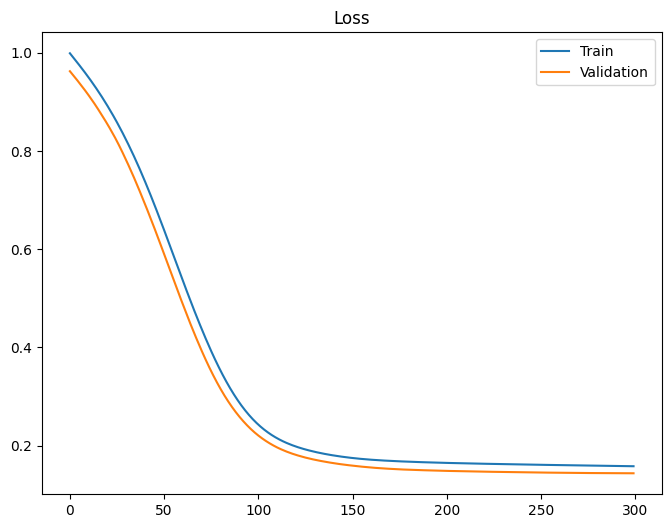

In [181]:
model = MLP(6, [20, 10], 1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def plot_history(history):
    _, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Loss')
    ax.plot(history['train_loss'], label='Train')
    ax.plot(history['val_loss'], label='Validation')
    ax.legend()

    plt.show()

num_epochs = 300
history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    outputs = model(x_train)
    train_loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)

    history['train_loss'].append(train_loss.item())
    history['val_loss'].append(val_loss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss.item():.4f}, "
          f"Val Loss: {val_loss.item():.4f}")

plot_history(history)

Lastly, a display of the validation data plotted against the predictions of the models. As is observed, the model predicts the prices of houses quite accurately. It is, however, safe to say that there are additional factors affecting the price of a the houses than the 6 input dimensions.

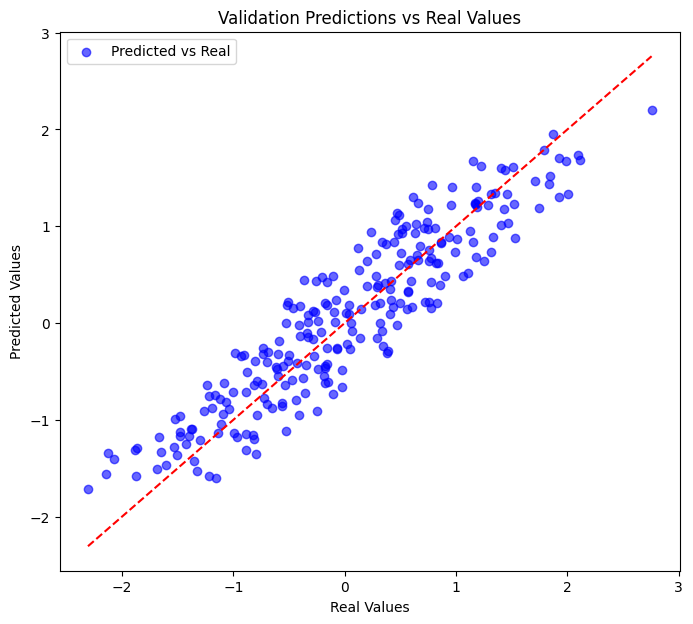

In [182]:
predictions = val_outputs.cpu().numpy()
real_values = y_val.cpu().numpy()

plt.figure(figsize=(8, 7))
plt.scatter(real_values, predictions, label='Predicted vs Real', color='blue', alpha=0.6)
plt.plot([real_values.min(), real_values.max()], [real_values.min(), real_values.max()], color='red', linestyle='--')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Validation Predictions vs Real Values')
plt.legend()
plt.show()

The plot with house prices converted to original.

/var/folders/f2/x94wm3_d56905yvhgb81pyx80000gn/T/ipykernel_65733/415732771.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(pred * p_std + p_mean)


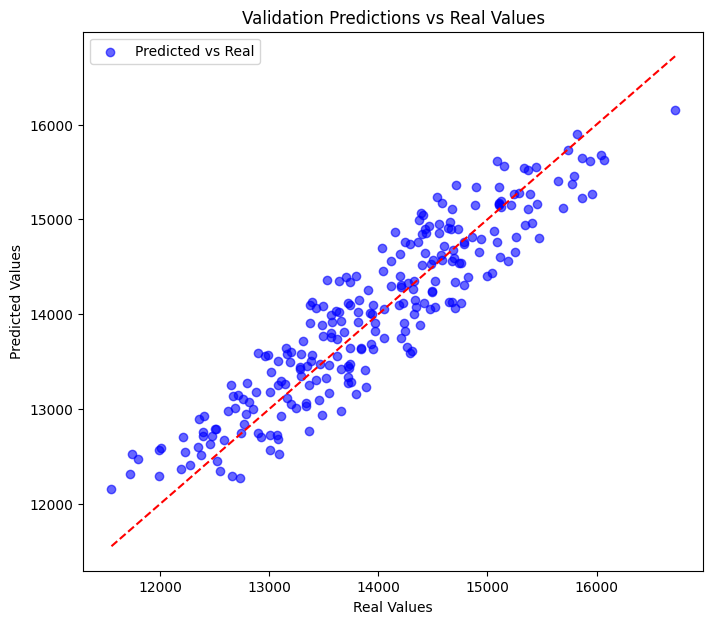

In [183]:
for i in range(real_values.shape[0]):
    real_values[i] = convert_values(real_values[i])
    predictions[i] = convert_values(predictions[i])

plt.figure(figsize=(8, 7))
plt.scatter(real_values, predictions, label='Predicted vs Real', color='blue', alpha=0.6)
plt.plot([real_values.min(), real_values.max()], [real_values.min(), real_values.max()], color='red', linestyle='--')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Validation Predictions vs Real Values')
plt.legend()
plt.show()